# Data source

The common data elements for predictive maintenance problems can be summarized as follows:

* Machine features: The features specific to each individual machine, e.g. engine size, make, model, location, installation date.
* Telemetry data: The operating condition data collected from sensors, e.g. temperature, vibration, operating speeds, pressures.
* Maintenance history: The repair history of a machine, e.g. maintenance activities or component replacements, this can also include error code or runtime message logs.
* Failure history: The failure history of a machine or component of interest.

It is possible that failure history is contained within maintenance history, either as in the form of special error codes or order dates for spare parts. In those cases, failures can be extracted from the maintenance data. Additionally, different business domains may have a variety of other data sources that influence failure patterns which are not listed here exhaustively. These should be identified by consulting the domain experts when building predictive models.

Some examples of above data elements from use cases are:
    
**Machine conditions and usage:** Flight routes and times, sensor data collected from aircraft engines, sensor readings from ATM transactions, train events data, sensor readings from wind turbines, elevators and connected cars.
    
**Machine features:** Circuit breaker technical specifications such as voltage levels, geolocation or car features such as make, model, engine size, tire types, production facility etc.

**Failure history:** fight delay dates, aircraft component failure dates and types, ATM cash withdrawal transaction failures, train/elevator door failures, brake disk replacement order dates, wind turbine failure dates and circuit breaker command failures.

**Maintenance history:** Flight error logs, ATM transaction error logs, train maintenance records including maintenance type, short description etc. and circuit breaker maintenance records.

Given the above data sources, the two main data types we observe in predictive maintenance domain are temporal data and static data. Failure history, machine conditions, repair history, usage history are time series indicated by the timestamp of data collection. Machine and operator specific features, are more static, since they usually describe the technical specifications of machines or operator’s properties.

For this scenario, we use a relatively large-scale data to walk the user through the main steps from data ingestion (this Jupyter notebook), feature engineering, model building, and model operationalization and deployment. The code for the entire process is written in PySpark and implemented using Jupyter notebooks within Azure ML Workbench. The selected model is operationalized using Azure Machine Learning Model Management for use in a production environment simulating making realtime failure predictions. 

# Step 1: Data Ingestion

This data aquisiton notebook will download the simulated predicitive maintenance data sets from our GitHub data store. We do some preliminary data cleaning and verification, and store the results as a Spark data frame in an Azure Blob storage container for use in the remaining notebook steps of this analysis.

**Note:** This notebook will take about 10-15 minutes to execute all cells, depending on the compute configuration you have setup. Most of this time is spent handling the _telemetry_ data set, which contains about 8.7 million records.

In [1]:
## Setup our environment by importing required libraries
import time
import os
import glob
import urllib

# Read csv file from URL directly
import pandas as pd

# For Azure blob storage access
from azure.storage.blob import BlockBlobService
from azure.storage.blob import PublicAccess

# For creating some preliminary EDA plots.
%matplotlib inline
import matplotlib.pyplot as plt
from ggplot import *

from datetime import datetime

# Setup the pyspark environment
from pyspark.sql import SparkSession

# For logging model evaluation parameters back into the
# AML Workbench run history plots.
import logging
from azureml.logging import get_azureml_logger

amllog = logging.getLogger("azureml")
amllog.level = logging.INFO

# Turn on cell level logging.
%azureml history on
%azureml history show

# Time the notebook execution. 
# This will only make sense if you "Run All" cells
tic = time.time()

logger = get_azureml_logger() # logger writes to AMLWorkbench runtime view
spark = SparkSession.builder.getOrCreate()

# Telemetry
logger.log('amlrealworld.predictivemaintenance.data_ingestion','true')

History logging enabled
History logging is enabled


### Azure Blob Storage Container

We will be storing intermediate results for use between these Jupyter notebooks in an Azure Blob Storage container. Instructions for setting up your Azure Storage account are available within this link (https://docs.microsoft.com/en-us/azure/storage/blobs/storage-python-how-to-use-blob-storage). You will need to copy your account name and account key from the _Access Keys_ area in the portal into the following code block. These credentials will be reused in all four Jupyter notebooks. 

We will handle creating the containers and writing the data to these containers for each notebook. Further instructions for using Azure Blob storage with AML Workbench are available
(https://github.com/Azure/ViennaDocs/blob/master/Documentation/UsingBlobForStorage.md).

You will need to enter the **ACCOUNT_NAME** as well as the **ACCOUNT_KEY** in order to access Azure Blob storage account you have created. This notebook will create and store all the resulting data files in a blob container under this account. 


In [2]:
# Enter your Azure blob storage details here 
ACCOUNT_NAME = "<your blob storage account name>"

# You can find the account key under the _Access Keys_ link in the 
# [Azure Portal](portal.azure.com) page for your Azure storage container.
ACCOUNT_KEY = "<your blob storage account key>"

#-------------------------------------------------------------------------------------------
# We will create this container to hold the results of executing this notebook.
# If this container name already exists, we will use that instead, however
# This notebook will ERASE ALL CONTENTS.
CONTAINER_NAME = "dataingestion"

# Connect to your blob service     
az_blob_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)

# Create a new container if necessary, otherwise you can use an existing container.
# This command creates the container if it does not already exist. Else it does nothing.
az_blob_service.create_container(CONTAINER_NAME, 
                                 fail_on_exist=False, 
                                 public_access=PublicAccess.Container)

False

## Download simulated data sets
We will be reusing the raw simulated data files from another tutorial. The notebook automatically downloads these files stored at [Microsoft/SQL-Server-R-Services-Samples GitHub site](https://github.com/Microsoft/SQL-Server-R-Services-Samples/tree/master/PredictiveMaintanenceModelingGuide/Data).

The five data files are:

 * machines.csv
 * maint.csv
 * errors.csv
 * telemetry.csv
 * failures.csv

To get an idea of what is contained in the data, we examine this machine schematic. 
![Machine schematic](../images/machine.png)

There are 1000 machines of four different models. Each machine contains four components of interest, and four sensors measuring voltage, pressure, vibration and rotation. A controller monitors the system and raises alerts for five different error conditions. Maintenance logs indicate when something is done to the machine which does not include a component replacement. A failure is defined by the replacement of a component. 

This notebook does some preliminary data cleanup, creates summary graphics for each data set to verify the data downloaded correctly, and stores the resulting data sets in the Azure blob container created in the previous section.

In [2]:
# The raw data is stored on GitHub here:
basedataurl = "http://media.githubusercontent.com/media/Microsoft/SQL-Server-R-Services-Samples/master/PredictiveMaintanenceModelingGuide/Data/"

# We will store each of these data sets in blob storage in an 
# Azure Storage Container on your Azure subscription.
# See https://github.com/Azure/ViennaDocs/blob/master/Documentation/UsingBlobForStorage.md
# for details.

# These file names detail which blob each files is stored under. 
MACH_DATA = 'machines_files.parquet'
MAINT_DATA = 'maint_files.parquet'
ERROR_DATA = 'errors_files.parquet'
TELEMETRY_DATA = 'telemetry_files.parquet'
FAILURE_DATA = 'failure_files.parquet'


### Machines data set

This simulation tracks a simulated set of 1000 machines over the course of a single year (2015). 

This data set includes information about each machine: Machine ID, model type and age (years in service). 

In [3]:
# load raw data from the GitHub URL
datafile = "machines.csv"

# Download the file once, and only once.
if not os.path.isfile(datafile):
    urllib.request.urlretrieve(basedataurl+datafile, datafile)
    
# Read into pandas
machines = pd.read_csv(datafile, encoding='utf-8')

print(machines.count())
machines.head(10)

machineID    1000
model        1000
age          1000
dtype: int64


,machineID,model,age
0,1,model2,18
1,2,model4,7
2,3,model3,8
3,4,model3,7
4,5,model2,2
5,6,model3,7
6,7,model4,20
7,8,model3,16
8,9,model1,7
9,10,model1,10


The following figure plots a histogram of the machines age colored by the specific model.

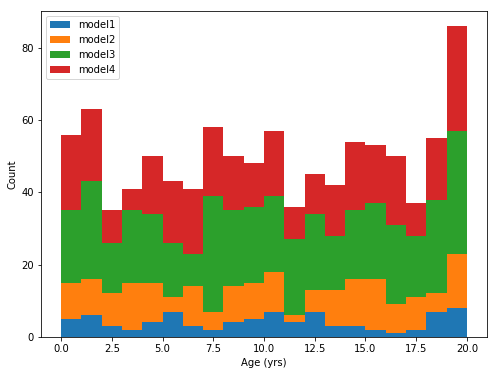

In [4]:
plt.figure(figsize=(8, 6))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.legend()

The figure shows how long the collection of machines have been in service. It indicates there are four model types, shown in different colors, and all four models have been in service over the entire 20 years of service. The machine age will be a feature in our analysis, since we expect older machines may have a different set of errors and failures then machines that have not been in service long.

Next, we convert the machines data to a Spark dataframe, and verify the data types have converted correctly. 

In [5]:
# The data was read in using a Pandas data frame. We'll convert 
# it to pyspark to ensure it is in a Spark usable form for later 
# manipulations.
mach_spark = spark.createDataFrame(machines, 
                                   verifySchema=False)

# We no longer need th pandas dataframe, so we can release that memory.
del machines

# Check data type conversions.
mach_spark.printSchema()

root
 |-- machineID: long (nullable = true)
 |-- model: string (nullable = true)
 |-- age: long (nullable = true)



Now we write the spark dataframe to an Azure blob storage container for use in the remaining notebooks of this scenario.

In [6]:
# Write the Machine data set to intermediate storage
mach_spark.write.mode('overwrite').parquet(MACH_DATA)

for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if MACH_DATA in blob.name:
        az_blob_service.delete_blob(CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(MACH_DATA + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(CONTAINER_NAME, name, name)

print("Machines files saved!")

NameError: name 'az_blob_service' is not defined

### Errors  data set

The error log contains non-breaking errors recorded while the machine is still operational. These errors are not considered failures, though they may be predictive of a future failure event. The error datetime field is rounded to the closest hour since the telemetry data (loaded later) is collected on an hourly rate.

In [7]:
# load raw data from the GitHub URL
datafile = "errors.csv"

# Download the file once, and only once.
if not os.path.isfile(datafile):
    urllib.request.urlretrieve(basedataurl+datafile, datafile)
    
# Read into pandas
errors = pd.read_csv(datafile, encoding='utf-8')

print(errors.count())
errors.head(10)

datetime     11967
machineID    11967
errorID      11967
dtype: int64


,datetime,machineID,errorID
0,2015-01-06 03:00:00,1,error3
1,2015-02-03 06:00:00,1,error4
2,2015-02-21 11:00:00,1,error1
3,2015-02-21 16:00:00,1,error2
4,2015-03-20 06:00:00,1,error1
5,2015-04-04 06:00:00,1,error5
6,2015-05-04 06:00:00,1,error4
7,2015-05-19 06:00:00,1,error2
8,2015-05-19 06:00:00,1,error3
9,2015-06-03 06:00:00,1,error5


The following histogram details the distribution of the errors tracked in the log files. 

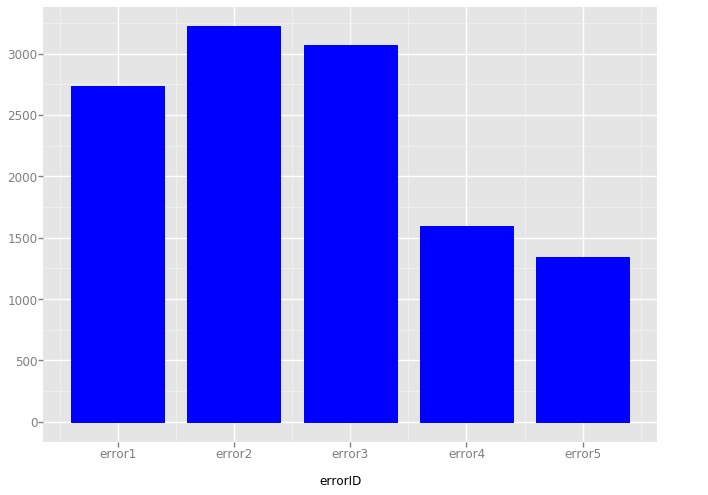

<ggplot: (-9223363242042572740)>

In [8]:
# Quick plot to show structure
ggplot(aes(x="errorID"), errors) + geom_bar(fill="blue", color="black")

The error data consists of a time series (datetime stamped) of error codes thrown by each machine (machineID). The figure shows how many errors occured in each of the five error classes over the entire year. We could split this figure over each individual machine, but with 1000 individuals, the figure would not be very informative.

Next, we convert the errors data to a Spark dataframe, and verify the data types have converted correctly. 

In [9]:
# The data was read in using a Pandas data frame. We'll convert 
# it to pyspark to ensure it is in a Spark usable form for later 
# manipulations.
error_spark = spark.createDataFrame(errors, 
                               verifySchema=False)

# We no longer need the pandas dataframe, so we can release that memory.
del errors

# Check data type conversions.
error_spark.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- machineID: long (nullable = true)
 |-- errorID: string (nullable = true)



Now we write the spark dataframe to an Azure blob storage container for use in the remaining notebooks of this scenario.

In [11]:
# Write the Errors data set to intermediate storage
error_spark.write.mode('overwrite').parquet(ERROR_DATA)
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if ERROR_DATA in blob.name:
        az_blob_service.delete_blob(CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(ERROR_DATA + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(CONTAINER_NAME, name, name)

print("Errors files saved!")

/azureml-run/errors_files.parquet/part-00004-00bee480-c221-4989-a665-6467631aa8a3-c000.snappy.parquet
/azureml-run/errors_files.parquet/part-00005-00bee480-c221-4989-a665-6467631aa8a3-c000.snappy.parquet
/azureml-run/errors_files.parquet/part-00003-00bee480-c221-4989-a665-6467631aa8a3-c000.snappy.parquet
/azureml-run/errors_files.parquet/_SUCCESS
/azureml-run/errors_files.parquet/part-00001-00bee480-c221-4989-a665-6467631aa8a3-c000.snappy.parquet
/azureml-run/errors_files.parquet/part-00002-00bee480-c221-4989-a665-6467631aa8a3-c000.snappy.parquet
/azureml-run/errors_files.parquet/part-00000-00bee480-c221-4989-a665-6467631aa8a3-c000.snappy.parquet
Errors files saved!


### Maintenance data set

The maintenance log contains both scheduled and unscheduled maintenance records. Scheduled maintenance corresponds with  regular inspection of components, unscheduled maintenance may arise from mechanical failure or other performance degradations. A failure record is generated for component replacement in the case  of either maintenance events. Because maintenance events can also be used to infer component life, the maintenance data has been collected over two years (2014, 2015) instead of only over the year of interest (2015).

In [10]:
# load raw data from the GitHub URL
datafile = "maint.csv"

# Download the file once, and only once.
if not os.path.isfile(datafile):
    urllib.request.urlretrieve(basedataurl+datafile, datafile)
    
# Read into pandas
maint = pd.read_csv(datafile, encoding='utf-8')

print(maint.count())
maint.head(20)

datetime     32592
machineID    32592
comp         32592
dtype: int64


,datetime,machineID,comp
0,2014-07-01 06:00:00,1,comp4
1,2014-09-14 06:00:00,1,comp1
2,2014-09-14 06:00:00,1,comp2
3,2014-11-13 06:00:00,1,comp3
4,2015-01-05 06:00:00,1,comp1
5,2015-01-20 06:00:00,1,comp1
6,2015-02-04 06:00:00,1,comp3
7,2015-02-19 06:00:00,1,comp3
8,2015-03-06 06:00:00,1,comp3
9,2015-03-21 06:00:00,1,comp1


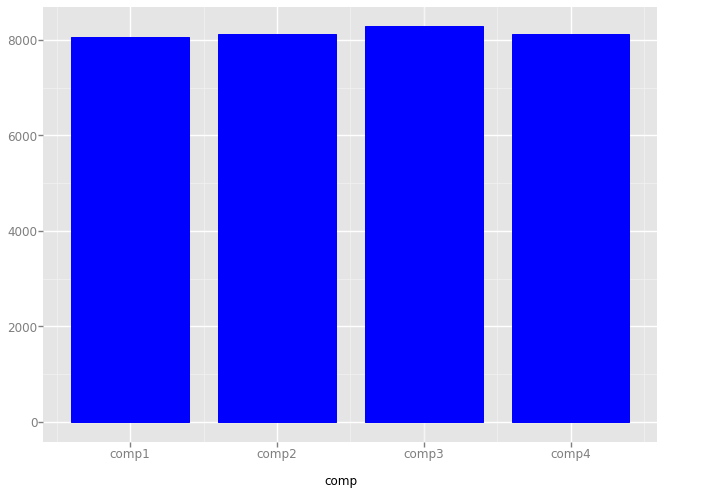

<ggplot: (8794812099960)>

In [11]:
# Quick plot to show structure
ggplot(aes(x="comp"), maint) + geom_bar(fill="blue", color="black")

The figure shows a histogram of component replacements divided into the four component types over the entire maintenance history. It looks like these four components are replaced at similar rates.

There are many ways we might want to look at this data including calculating how long each component type lasts, or the time history of component replacements within each machine. This will take some preprocess of the data, which we are delaying until we do the feature engineering steps in the next example notebook.

Next, we convert the errors data to a Spark dataframe, and verify the data types have converted correctly. 

In [12]:
# The data was read in using a Pandas data frame. We'll convert 
# it to pyspark to ensure it is in a Spark usable form for later 
# manipulations.
maint_spark = spark.createDataFrame(maint, 
                              verifySchema=False)

# We no longer need the pandas dataframe, so we can release that memory.
del maint

# Check data type conversions.
maint_spark.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- machineID: long (nullable = true)
 |-- comp: string (nullable = true)



Now we write the spark dataframe to an Azure blob storage container for use in the remaining notebooks of this scenario.

In [15]:
# Write the Maintenance data set to intermediate storage
maint_spark.write.mode('overwrite').parquet(MAINT_DATA)
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if MAINT_DATA in blob.name:
        az_blob_service.delete_blob(CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(MAINT_DATA + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(CONTAINER_NAME, name, name)

print("Maintenance files saved!")

/azureml-run/maint_files.parquet/part-00003-339f5e48-c727-4cd7-8483-ab6e0be42d39-c000.snappy.parquet
/azureml-run/maint_files.parquet/part-00004-339f5e48-c727-4cd7-8483-ab6e0be42d39-c000.snappy.parquet
/azureml-run/maint_files.parquet/part-00000-339f5e48-c727-4cd7-8483-ab6e0be42d39-c000.snappy.parquet
/azureml-run/maint_files.parquet/part-00002-339f5e48-c727-4cd7-8483-ab6e0be42d39-c000.snappy.parquet
/azureml-run/maint_files.parquet/_SUCCESS
/azureml-run/maint_files.parquet/part-00001-339f5e48-c727-4cd7-8483-ab6e0be42d39-c000.snappy.parquet
/azureml-run/maint_files.parquet/part-00005-339f5e48-c727-4cd7-8483-ab6e0be42d39-c000.snappy.parquet
Maintenance files saved!


### Telemetry data set

The telemetry time-series data consists of voltage, rotation, pressure, and vibration sensor measurements collected from each  machines in real time. The data is averaged over an hour and stored in the telemetry logs.

In [15]:
# Github has been having some timeout issues. This should fix the problem for this dataset.
import socket
socket.setdefaulttimeout(30)

# load raw data from the GitHub URL
datafile = "telemetry.csv"

# Download the file once, and only once.
if not os.path.isfile(datafile):
    urllib.request.urlretrieve(basedataurl+datafile, datafile)
    
# Read into pandas
telemetry = pd.read_csv(datafile, encoding='utf-8')

# handle missing values
# define groups of features 
features_datetime = ['datetime']
features_categorical = ['machineID']
features_numeric = list(set(telemetry.columns) - set(features_datetime) - set(features_categorical))

# Replace numeric NA with 0
telemetry[features_numeric] = telemetry[features_numeric].fillna(0)

# Replace categorical NA with 'Unknown'
telemetry[features_categorical]  = telemetry[features_categorical].fillna("Unknown")

# Counts...
print(telemetry.count())

# Examine 10 rowzs of data.
telemetry.head(10)

datetime     8761000
machineID    8761000
volt         8761000
rotate       8761000
pressure     8761000
vibration    8761000
dtype: int64


,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,151.919999,530.813578,101.788175,49.604013
1,2015-01-01 07:00:00,1,174.522001,535.523532,113.256009,41.515905
2,2015-01-01 08:00:00,1,146.912822,456.080746,107.786965,42.099694
3,2015-01-01 09:00:00,1,179.530561,503.469990,108.283817,37.847727
4,2015-01-01 10:00:00,1,180.544277,371.600611,107.553307,41.467880
5,2015-01-01 11:00:00,1,141.411757,530.857266,87.614001,44.985846
6,2015-01-01 12:00:00,1,184.083822,450.227529,87.697380,30.831263
7,2015-01-01 13:00:00,1,166.632618,486.466838,108.067734,50.380054
8,2015-01-01 14:00:00,1,159.892748,488.968697,102.131884,43.661297
9,2015-01-01 15:00:00,1,176.686812,508.202759,90.951189,43.039696


In [17]:
# Check the incoming schema, we want to convert datetime to the correct type.
# format datetime field which comes in as string
telemetry.dtypes

datetime      object
machineID      int64
volt         float64
rotate       float64
pressure     float64
vibration    float64
dtype: object

Rather than plot 8.7 million data points, this figure plots a month of measurements for a single machine. This is representative of each feature repeated for every machine over the entire year of sensor data collection.

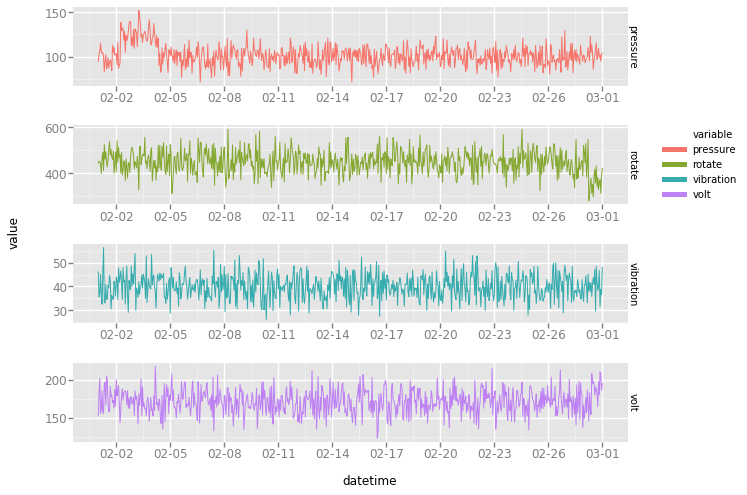

<ggplot: (-9223363291661859689)>

In [18]:
plt_data = telemetry.loc[telemetry['machineID'] == 1]

# format datetime field which comes in as string
plt_data['datetime'] = pd.to_datetime(plt_data['datetime'], format="%Y-%m-%d %H:%M:%S")


# Quick plot to show structure
plot_df = plt_data.loc[(plt_data['datetime'] >= pd.to_datetime('2015-02-01')) &
                       (plt_data['datetime'] <= pd.to_datetime('2015-03-01'))]

plt_data = pd.melt(plot_df, id_vars=['datetime', 'machineID'])

ggplot(aes(x="datetime", y="value", color = "variable", group="variable"), plt_data) +\
    geom_line() +\
    scale_x_date(labels=date_format('%m-%d')) +\
    facet_grid('variable', scales='free_y')

The figure shows one month worth of telemetry sensor data for one machine. Each sensor is shown in it's own panel.

Next, we convert the errors data to a Spark dataframe, and verify the data types have converted correctly. 

In [19]:
# The data was read in using a Pandas data frame. We'll convert 
# it to pyspark to ensure it is in a Spark usable form for later 
# manipulations.
# This line takes about 9.5 minutes to run.
telemetry_spark = spark.createDataFrame(telemetry, verifySchema=False)

# We no longer need the pandas dataframes, so we can release that memory.
del telemetry
del plt_data
del plot_df

# Check data type conversions.
telemetry_spark.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- machineID: long (nullable = true)
 |-- volt: double (nullable = true)
 |-- rotate: double (nullable = true)
 |-- pressure: double (nullable = true)
 |-- vibration: double (nullable = true)



Now we write the spark dataframe to an Azure blob storage container for use in the remaining notebooks of this scenario.

In [20]:
# Write the telemetry data set to intermediate storage
telemetry_spark.write.mode('overwrite').parquet(TELEMETRY_DATA)
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if TELEMETRY_DATA in blob.name:
        az_blob_service.delete_blob(CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(TELEMETRY_DATA + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(CONTAINER_NAME, name, name)

print("Telemetry files saved!")

/azureml-run/telemetry_files.parquet/part-00005-ab2f327f-0b54-4713-b947-9636b9cae6b2-c000.snappy.parquet
/azureml-run/telemetry_files.parquet/part-00003-ab2f327f-0b54-4713-b947-9636b9cae6b2-c000.snappy.parquet
/azureml-run/telemetry_files.parquet/part-00004-ab2f327f-0b54-4713-b947-9636b9cae6b2-c000.snappy.parquet
/azureml-run/telemetry_files.parquet/part-00001-ab2f327f-0b54-4713-b947-9636b9cae6b2-c000.snappy.parquet
/azureml-run/telemetry_files.parquet/_SUCCESS
/azureml-run/telemetry_files.parquet/part-00000-ab2f327f-0b54-4713-b947-9636b9cae6b2-c000.snappy.parquet
/azureml-run/telemetry_files.parquet/part-00002-ab2f327f-0b54-4713-b947-9636b9cae6b2-c000.snappy.parquet
Telemetry files saved!


### Failures data set

Failures correspond to component replacements within the maintenance log. Each record contains the Machine ID, component type, and replacement datetime. These records will be used to create the machine learning labels we will be trying to predict.

In [21]:
# load raw data from the GitHub URL
datafile = "failures.csv"

# Download the file once, and only once.
if not os.path.isfile(datafile):
    urllib.request.urlretrieve(basedataurl+datafile, datafile)
    
# Read into pandas
failures = pd.read_csv(datafile, encoding='utf-8')

print(failures.count())
failures.head(10)

datetime     6726
machineID    6726
failure      6726
dtype: int64


,datetime,machineID,failure
0,2015-02-04 06:00:00,1,comp3
1,2015-03-21 06:00:00,1,comp1
2,2015-04-05 06:00:00,1,comp4
3,2015-05-05 06:00:00,1,comp3
4,2015-05-20 06:00:00,1,comp2
5,2015-06-04 06:00:00,1,comp4
6,2015-06-19 06:00:00,1,comp2
7,2015-08-03 06:00:00,1,comp3
8,2015-08-03 06:00:00,1,comp4
9,2015-11-01 06:00:00,1,comp4


The following histogram details the distribution of the failure records obtained from failure log. This log was built originally from component replacements the maintenance log file. 

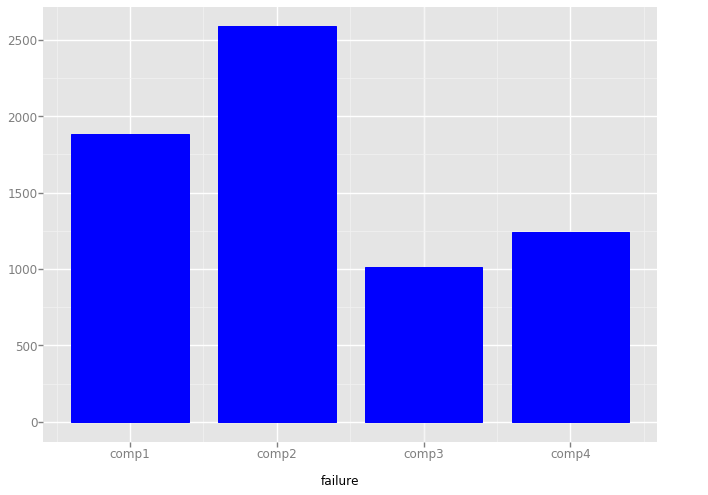

<ggplot: (-9223363291607340670)>

In [22]:
# Plot failures
ggplot(aes(x="failure"), failures) + geom_bar(fill="blue", color="black")

The figure shows failure related replacements occured for each of the 4 component types over the entire year.

Next, we convert the maintenance data to PySpark and store it in an Azure blob.

In [23]:
# The data was read in using a Pandas data frame. We'll convert 
# it to pyspark to ensure it is in a Spark usable form for later 
# manipulations.
failures_spark = spark.createDataFrame(failures, 
                                       verifySchema=False)

# Check data type conversions.
failures_spark.printSchema()

root
 |-- datetime: string (nullable = true)
 |-- machineID: long (nullable = true)
 |-- failure: string (nullable = true)



Now we write the spark dataframe to an Azure blob storage container for use in the remaining notebooks of this scenario.

In [24]:
# Write the failures data set to intermediate storage
failures_spark.write.mode('overwrite').parquet(FAILURE_DATA)
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if FAILURE_DATA in blob.name:
        az_blob_service.delete_blob(CONTAINER_NAME, blob.name)

# upload the entire folder into blob storage
for name in glob.iglob(FAILURE_DATA + '/*'):
    print(os.path.abspath(name))
    az_blob_service.create_blob_from_path(CONTAINER_NAME, name, name)

print("Failure files saved!")

# Time the notebook execution. 
# This will only make sense if you "Run All" cells
toc = time.time()
print("Full run took %.2f minutes" % ((toc - tic)/60))

logger.log("Data Ingestion Run time", ((toc - tic)/60))

/azureml-run/failure_files.parquet/part-00001-d32551dc-ad2a-41b9-9bd2-92bee67bbd4f-c000.snappy.parquet
/azureml-run/failure_files.parquet/part-00004-d32551dc-ad2a-41b9-9bd2-92bee67bbd4f-c000.snappy.parquet
/azureml-run/failure_files.parquet/part-00003-d32551dc-ad2a-41b9-9bd2-92bee67bbd4f-c000.snappy.parquet
/azureml-run/failure_files.parquet/part-00005-d32551dc-ad2a-41b9-9bd2-92bee67bbd4f-c000.snappy.parquet
/azureml-run/failure_files.parquet/part-00002-d32551dc-ad2a-41b9-9bd2-92bee67bbd4f-c000.snappy.parquet
/azureml-run/failure_files.parquet/_SUCCESS
/azureml-run/failure_files.parquet/part-00000-d32551dc-ad2a-41b9-9bd2-92bee67bbd4f-c000.snappy.parquet
Failure files saved!
Full run took 9.91 minutes


## Conclusion

We have now downloaded the required data files in csv format. We converted the data into Pandas data frames so we could generate a few graphs to help us understand what was in each data file. Then saved them into an Azure Blob storage container as Spark data frames for use in the remaining analysis steps. The `Code\2_feature_engineering.ipynb` Jupyter notebook will read these spark data frames from Azure blob and generate the modeling features for out predictive maintenance machine learning model.